# Probabilistic Programming - Assignment

Year: 2022-2023

In [1]:
# Enter your name and student ID
#name = Liu, Haoru
#ID   = 1782932

In this assignment, we will go through the Bayesian model design cycle:

 <img src="figures/modelling-procedure.png" alt="" width="600"> 

In questions 1 and 2, you will build a simple model, fit it to data and evaluate its performance on future data. You will find that its performance is not great. In question 3, you will improve the model in multiple ways. Finally, in question 4, you will do model selection based on free energy.

The final questions will require knowledge from the last probabilistic programming session. But questions 1 and 2 can be done relatively early in the course.

In [2]:
using Pkg
Pkg.activate("/root/work/")
Pkg.instantiate();

  Activating project at `~/work`


In [3]:
using CSV
using DataFrames
using LinearAlgebra
using ProgressMeter
using RxInfer
using Plots
default(label="",
        grid=false, 
        linewidth=3, 
        markersize=4,
        guidefontsize=12, 
        margins=15Plots.pt)

## Problem: Forecasting Air Quality

Many Europeans suspect that the air quality in their city is declining. A [recent study](https://doi.org/10.1016/j.snb.2007.09.060) measured the air quality of a major city in North Italy using an electronic nose. The measurements were made in the middle of the city and reflect urban activity. We will inspect the specific chemical concentrations found and build a model to accurately predict CO for future time points.

![https://www.theguardian.com/environment/2020/apr/07/air-pollution-linked-to-far-higher-covid-19-death-rates-study-finds](figures/air-milan-wide.png)

Photograph taken by Claudio Furlan/LaPresse/Zuma Press/Rex/Shutterstock ([link](https://www.theguardian.com/environment/2020/apr/07/air-pollution-linked-to-far-higher-covid-19-death-rates-study-finds))

The data can be found here: https://archive.ics.uci.edu/ml/datasets/Air+Quality. I've done some pre-processing and selected the most important features. In this assignment we will infer parameters in a model of the data and predict air quality in the future. For that purpose, the data has been split into past and future.

In [4]:
# Load training data
past_data = DataFrame(CSV.File("/work/data/airquality_past.csv"))

Row,time,CO
,DateTime,Float64
1,2004-03-10T18:00:00,1360.0
2,2004-03-10T19:00:00,1292.0
3,2004-03-10T20:00:00,1402.0
4,2004-03-10T21:00:00,1376.0
5,2004-03-10T22:00:00,1272.0
6,2004-03-10T23:00:00,1197.0
7,2004-03-11T00:00:00,1185.0
8,2004-03-11T01:00:00,1136.0
9,2004-03-11T02:00:00,1094.0


Let's visualize the carbon monoxide measurements over time.

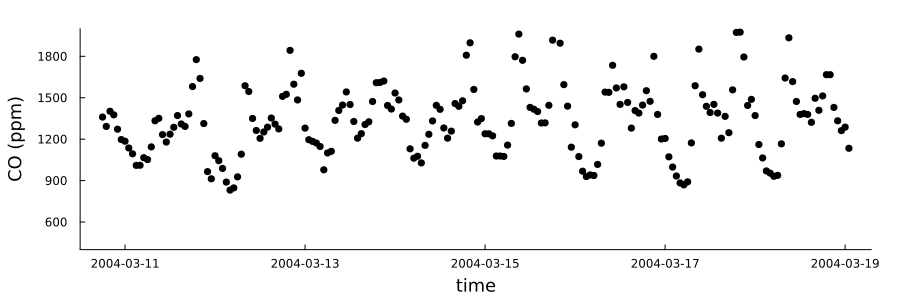

In [5]:
scatter(past_data[:,1], 
        past_data[:,2], 
        size=(900,300), 
        color="black", 
        xlabel="time", 
        ylabel="CO (ppm)",
        ylims=[400,2000])

## 1. Model specification & parameter estimation

We suspect that there is a temporal dependence in this dataset. In other words, the data changes relatively slowly over time and neighbouring data points end up being highly correlated. To exploit this correlation, we will build an _auto-regressive model_ of the form:

$$ y_k = \theta y_{k-1} + \epsilon_k \, , $$

where the noise $\epsilon_k$ is drawn from a zero-mean Gaussian with precision parameter $\tau$: 

$$ \epsilon_k \sim \mathcal{N}(0, \tau^{-1}) \, .$$

Tasks:
- [1pt] Specify the above equation as a probabilistic model in RxInfer, using $\tau = 1.0$.
- [1pt] Specify and execute an inference procedure to infer a posterior distribution for $\theta$.
- [1pt] Plot the inferred distribution over the interval $[0,\ 2]$.

In [17]:
### YOUR CODE HERE
@model function auto_regression()
    N = 200
    θ = randomvar()
    y = datavar(Float64, N)
    tau = 1.0

    θ ~ Normal(0, 1)
    y[1] ~ Normal(0, tau^-1)

    for i = 2:N
        y[i] ~ NormalMeanVariance(y[i-1]*θ, tau^-1)
    end
    return y, θ
end

results = inference(
    model       = auto_regression(),
    #data        = (y = past_data),
    data = (y = past_data[!, "CO"],),
    returnvars  = (θ = KeepEach()),
    #initmarginals = (θ = MvNormalMeanPrecision(0, 1))
    #initmarginals = (γ = GammaShapeRate(1.0, 1.0), θ = MvNormalMeanPrecision(zeros(1), diageye(1)))
    initmarginals = (γ = GammaShapeRate(1.0, 1.0), θ = MvNormalMeanPrecision(0, 1))
)

pθ = plot()
θms = mean.(θ)
θvs = var.(θ)
pθ = plot!(pθ, [θms θms+2*sqrt.(θvs) θms-2*sqrt.(θvs)], seriestype = :ribbon, label = " θ", fillalpha = 0.2)
pθ = plot!(pθ, [θms], seriestype = :hline, label = " θ")
pθ = plot!(pθ, xlim = (0, 2))
display(pθ)


LoadError: MethodError: no method matching MvNormalMeanPrecision(::Int64, ::Int64)

## 2. Predictions & model evaluation

We want to evaluate the parameters inferred under the model. For now, we will do this by visually inspecting the 1-step ahead predictions on our data set. Later, we will use free energy as a metric. 

The posterior predictive distribution for the next time step is:

$$ p(y_{t+1} \mid y_{t}, \mathcal{D}) = \int p(y_{t+1} \mid \theta, y_{t}) p(\theta \mid \mathcal{D}) \, \mathrm{d}\theta \, , $$

where $\mathcal{D}$ refers to the data used to infer the posterior distribution. To make 1-step ahead predictions, you will have to loop over the data (i.e., `for t in 1:T`), plug in the current data point and compute the parameters of the posterior predictive distribution for the next data point. You may start from $t=2$, using $y_1$ as initial "previous observation". 

Tasks:
- [1pt] Derive the parameters of the posterior predictive and compute the 1-step ahead predictions on the data set.
- [1pt] Plot the first 10 predictions (posterior predictive variance in `ribbon=`) along with $y_{2:11}$ (scatterplot).

---

Note that if you failed to infer a posterior distribution in the previous question, you can still answer this question using a standard normal, $p(\theta) = \mathcal{N}(0,1)$.

In [20]:
### YOUR CODE HERE
# Compute the posterior predictive mean and variance
mu_pred = y[1].*mean!(θ)
var_pred = var(θ)/tau + (y[1]^2)*var(θ)
predictions = [mu_pred]
pred_upper = [mu_pred + 2*sqrt(var_pred)]
pred_lower = [mu_pred - 2*sqrt(var_pred)]

for t = 2:10
    mu_pred = y[t-1]*mean!(θ)
    var_pred = var(θ)./tau + (y[t-1]^2).*var(θ)
    push!(predictions, mu_pred)
    push!(pred_upper, mu_pred + 2*sqrt(var_pred))
    push!(pred_lower, mu_pred - 2*sqrt(var_pred))
end

# Plot the predictions
p = scatter(y[2:11], label = "y2:11")
plot!(p, predictions, seriestype = :line, label = "Predictions")
plot!(p, pred_upper, pred_lower, seriestype = :ribbon, label = "Prediction interval", fillalpha = 0.2)
display(p)


LoadError: ArgumentError: syntax df[column] is not supported use df[!, column] instead

## 3. Model critiqueing & improvement

From the results of the previous question, you may conclude that our initial model isn't great: it only considers extremely short-term changes, which are highly affected by noise. 

The model can be improved in two ways:
1. We set the noise level $\tau$ to $1.0$ but that was based on convenience, not on domain expertise or data. You are going to put a prior probability distribution over $\tau$ and infer a posterior $p(\tau \mid \mathcal{D})$ simultaneously. 
2. We can consider changes over longer periods of time by increasing the model order of the auto-regressive model. That corresponds to:

$$ y_k = \sum_{m=1}^{M} \theta_m y_{k-m} + \epsilon_k \, ,$$

where $M$ corresponds to model order.

Tasks:
- [1pt] Specify a higher-order AR model with an order parameter $M$, and with noise precision as a random variable.
- [1pt] Infer the approximate posteriors for $\theta$ and $\tau$, for model order $M=3$.
- [1pt] Visualize the posterior for the noise distribution $q(\tau)$ and the 1-step ahead predictions (mean and variance) on the data.

In [8]:
# Number of iterations of variational inference
n_iters = 10;

# Model order
M = 5;

In [9]:
### YOUR CODE HERE
using Flux

# model definition
M = 3 # order of the model
model = Model()
@RV θ[1:M] ~ GaussianMeanVariance(zeros(M), ones(M))
@RV τ ~ Gamma(2,2)
for i in 4:length(y)
    @RV y[i] ~ GaussianMeanPrecision(dot(θ[1:M], y[i-1:i-M]), τ)
end

# inference
inference = SGHMC(model, y, num_samples=1000, lr=0.05)

# plot the posterior distribution of the noise precision
plot(inference, :τ, :histogram, legend=false)

# compute the 1-step ahead predictions
y_pred = zeros(length(y))
y_pred_var = zeros(length(y))
for i in 4:length(y)
    (y_pred[i], y_pred_var[i]) = predict(inference, :y, i)
end

# plot the 1-step ahead predictions
p = plot(y[4:end], ribbon=y_pred_var[4:end], legend=false)
scatter!(1:length(y[4:end]), y_pred[4:end], c=:blue)


LoadError: ArgumentError: Package Flux not found in current path.
- Run `import Pkg; Pkg.add("Flux")` to install the Flux package.

## 4. Model selection & deployment

We now essentially have a different model for each value of $M$. Which is the best?

Tasks:
- [1pt] Compute the free energies for a given range of model orders and report the best performing one.
- [1pt] Deploy the best model (i.e., compute 1-step ahead predictions) on future data.

In [10]:
# Model order range
model_orders = [2,4,8,16,32];

In [11]:
### YOUR CODE HERE

In [12]:
# Load test data
future_data = DataFrame(CSV.File("/work/data/airquality_future.csv"))

LoadError: ArgumentError: "data/airquality_future.csv" is not a valid file or doesn't exist

In [13]:
### YOUR CODE HERE

## Submission

Before you submit the assignment, **make sure your notebook runs correctly**! You can do that by going to the `Kernel` tab in the toolbar and pressing `Restart & Run All`. 

This is important! If your code doesn't run, we can't verify the correctness of your answer.

When you're ready, head on over to Canvas and upload your notebook.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=97cbdf33-8f15-45ed-99ee-09730c4699dc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>